In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

import torch

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

    
print(device)

cuda:0


In [3]:
home = np.array([0.5, 0.5])
pts_in = np.random.rand(1000,2)

pts_1 = pts_in
print(pts_in)

max_charge = 3.0
pts = np.vstack((home, pts_in))


[[0.419596   0.37914087]
 [0.60991535 0.23008724]
 [0.43425393 0.65317721]
 ...
 [0.78906968 0.30440267]
 [0.7365312  0.51943429]
 [0.36928025 0.3159557 ]]


In [10]:
def distance(pt1, pt2):
    return np.sqrt((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)

def cal_center_dis(pts):
    home = pts[0]
    center_dis = {}
    indices_for_order = {}
    for i in range(1,len(pts)):
        key = str(pts[i])
        center_dis[key] = distance(home, pts[i])
        indices_for_order[key] = i
    return (center_dis, indices_for_order)

center_dis = cal_center_dis(pts)


def cal_visited_map(pts):
    visited_map = {}
    for i in range(0,len(pts)):
        key = str(pts[i])
        visited_map[key] = 0
    return visited_map

visited_map = cal_visited_map(pts)

In [11]:
class span:
    def __init__(self, pts, center_dis, visited_map, max_charge = 3):
        self.max_charge = max_charge
        self.curr_charge = self.max_charge
        self.min_charge = 0.75
        self.pts = pts[1:-1]
        self.home = pts[0]
        self.center_dis = center_dis[0]
        self.indices_for_order = center_dis[1]
        self.visited_map = visited_map
        self.path = []
        self.curr_path = []
        self.sorted_distance = {}

    def sort_dict(self):
        sorted_keys = sorted(self.center_dis, key=self.center_dis.get)  # [1, 3, 2]
        for w in sorted_keys:
            self.sorted_distance[w] = self.center_dis[w]
        return self.sorted_distance
    
    def get_sort_list(self):
        self.sort_dict()
        key_list = np.array(list(self.sorted_distance))
        data = []
        for i in range(0,len(key_list)):
            a = key_list[i].split()
            a_new = []
            for j in range(0, len(a)):
                element = a[j]
                new_elem = []
                for el in element:
                    if el == '[' or el == ']':
                        pass
                    else:
                        new_elem.append(el)
                new_elem = ''.join(new_elem)
                if len(new_elem) > 0:
                    f_new = float(new_elem)
                    a_new.append(f_new)
            cur = np.asarray(a_new)
            data.append(cur)
        data_set = np.array(data)
        return data_set

    def get_order(self, key_list):
        order = []
        for idx in range(len(key_list)):
            order.append(self.indices_for_order[str(key_list[idx])])
        return order

    def plan_A(self):
        prev_pt = self.home     
        random_idx_list = list(range(0,len(self.pts)))

        while len(random_idx_list) > 0:
            random_idx = np.random.choice(random_idx_list)
            curr_point = self.pts[random_idx]
            
            if not self.visited_map[str(curr_point)]:
#                 print("IF_One")
                if prev_pt[0] == self.home[0] and prev_pt[1] == self.home[1]:
                    random_idx_list.remove(random_idx)
                    curr_dis = self.center_dis[str(curr_point)]
                    self.curr_charge -= curr_dis
                    self.visited_map[str(curr_point)] = 1
                    self.curr_path.append(list(curr_point))
                    prev_pt = curr_point
                    
                elif self.curr_charge - distance(prev_pt, curr_point) > self.min_charge: 
                    random_idx_list.remove(random_idx)
                    curr_dis = distance(prev_pt, curr_point)
                    self.curr_charge -= curr_dis
                    self.visited_map[str(curr_point)] = 1
                    self.curr_path.append(list(curr_point))
                    prev_pt = curr_point
#                     print(self.curr_charge)
                    
                else:
#                     print(self.curr_charge)
                    self.curr_charge = 3
                    self.visited_map[str(home)] += 1
                    self.curr_path.insert(0, list(self.home))
                    self.curr_path.append(list(self.home))
                    self.path.append(self.curr_path)
                    self.curr_path = []
                    prev_pt = self.home

        return self.path

In [12]:
Span = span(pts, center_dis, visited_map)

path_A = Span.plan_A()

In [13]:
print(len(path_A))

241


<Figure size 432x288 with 0 Axes>

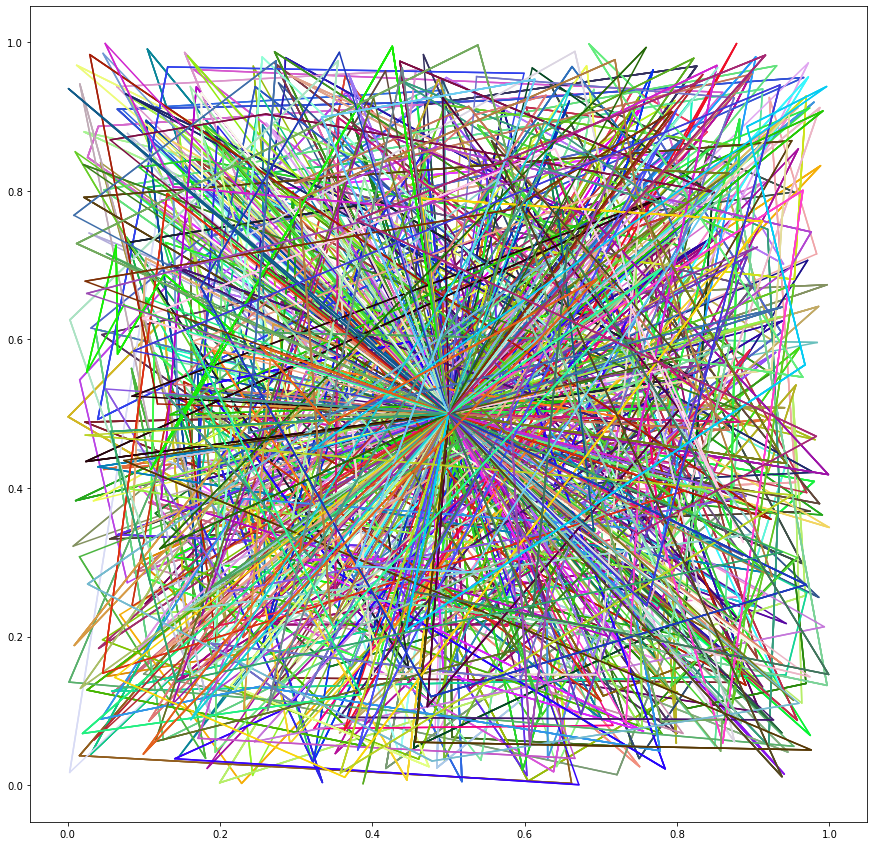

In [14]:
fig = plt.figure(1)
plt.figure(figsize=(15, 15))


color_list = []

for i in range(0,len(path_A)):
    r = np.random.random()
    b = np.random.random()
    g = np.random.random()
    color = (r, g, b)
    color_list.append(color)


for p in range(0,len(path_A)):
    x_value = []
    y_value = []
    for elem in path_A[p]:
        x1, y1 = elem[0], elem[1]
        x_value.append(y1)
        y_value.append(x1)
        plt.plot(x_value, y_value, c = color_list[p])
plt.savefig("path_A.png")
plt.show()